# Creacion y entrenamiento de la red neuronal reducida

In [15]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
import visualkeras
import pickle

# Para mostrar gráficas
import matplotlib.pyplot as plt
%matplotlib inline

# Anaconda fixing problem
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Establecemos una semilla para numpy y tensorflow para poder reproducir la ejecución y los resultados
seed =45
np.random.seed(seed)
tf.random.set_seed(seed)



# **Carga de datos**

### Cargar datos de produccion solar

In [3]:

input_produccion='Datos\produccion_por_provincia_y_fecha.json'
df_produccion = pd.read_json(input_produccion)
df_produccion['fecha_produccion_formateada'] = pd.to_datetime(df_produccion['fecha_produccion']).apply(lambda x: x.strftime('%Y-%m-%d %H%M%S'))
df_produccion['fecha_produccion_formateada_mes'] = pd.to_datetime(df_produccion['fecha_produccion']).apply(lambda x: x.strftime('%m/%Y'))
primera_columna= df_produccion.pop('fecha_produccion_formateada')
segunda_columna= df_produccion.pop('fecha_produccion_formateada_mes')
df_produccion.insert(1, 'fecha_produccion_formateada', primera_columna)
df_produccion.insert(2, 'fecha_produccion_formateada_mes', segunda_columna)

### Cargar imágenes Generadas

In [4]:

input_imagenes='Datos\Imagenes_generadas'
carpetas = sorted(os.listdir(input_imagenes))

imagenes_path=[]
imagenes_fecha=[]
for carpeta in carpetas:
  carpetas_path=input_imagenes+'/'+carpeta
  if not carpeta.endswith('.ini'):
    imagenes=os.listdir(carpetas_path)
    for imagen in imagenes:
      if imagen.endswith('.png'):
        imagenes_path.append(carpetas_path +'/'+imagen)
        imagenes_fecha.append(imagen.split('.')[0])

df_imagenes_path=pd.DataFrame({'imagenes_path': imagenes_path, 'imagenes_fecha': imagenes_fecha})

### Cargar potencia instalada

In [5]:

input_potencia='Datos\Potencia instalada Red Electrica\potencia_instalada.csv'
df = pd.read_csv(input_potencia, sep=";")
df_potencia = df.T.reset_index()
df_potencia.columns = df_potencia.iloc[0]
df_potencia = df_potencia.iloc[1:]

### Crear dataset con imágenes, potencia instalada y producción y guardarlo en un .json

In [8]:
#Unir los tres dataframes
df_data = pd.merge(df_produccion,df_imagenes_path, left_on = ['fecha_produccion_formateada'], right_on=['imagenes_fecha'], how = 'inner',suffixes=('','_COLUMNS_MERGE'))
#Obtenemos los casos en los que tenemos info para las 47 provincias
df_data=df_data[df_data['cantidad_provincias']==47]
df_data_final = pd.merge(df_data,df_potencia, left_on = ['fecha_produccion_formateada_mes'], right_on=['potencia_fecha'], how = 'left',suffixes=('','_COLUMNS_MERGE'))

output_file='Datos\dataset_train.json'
df_data_final.to_json(output_file)

# Creación del dataset de Train y Test

### Split aleatorio de los DataFrames con un 80% para entrenamiento y un 20% para evaluación 

In [11]:
df_aleatorio = df_data_final.sample(frac=1, random_state=42)  #frac=1: se selecciona el 100% de las filas
#df_aleatorio=df_aleatorio.head(1000)

# Restablecer los índices si lo deseas
df_aleatorio.reset_index(drop=True, inplace=True)

df_train = df_aleatorio.sample(frac=0.8, random_state=42)
df_test = df_aleatorio.drop(df_train.index)

### Carga de datos con tensorflow en un dataset

In [32]:
dataset_train_raw = tf.data.Dataset.from_tensor_slices((df_train['imagenes_path'],
                                                        df_train['potencia_solar_fotovoltaica'].apply(np.array).to_list(),
                                                        df_train['produccion'].apply(np.array).to_list()))

dataset_test_raw = tf.data.Dataset.from_tensor_slices((df_test['imagenes_path'],
                                                        df_test['potencia_solar_fotovoltaica'].apply(np.array).to_list(),
                                                        df_test['produccion'].apply(np.array).to_list()))
len_train=dataset_train_raw.cardinality().numpy()
len_test=dataset_test_raw.cardinality().numpy()
print(len_train,len_test)

20708 5177


### Preprocesado de las imágenes y división en batch

In [33]:
batch_size=32

def load_and_preprocess_image(image_path, potencia, label,jpg=True, size=(128,128)):
    # Cargar y decodificar la imagen usando TensorFlow
    try:
      img = tf.io.read_file(image_path)
      if jpg:
        img = tf.image.decode_jpeg(img, channels=3)  # Ajusta según el formato de tus imágenes
      else:
        img = tf.image.decode_png(img, channels=3)  # Ajusta según el formato de tus imágenes
      img = tf.image.resize(img, size)  # Redimensionar según tus necesidades
      img = img / 255.0  # Normalizar la imagen al rango [0, 1]
    except Exception as e:
      print("Error al cargar la imagen. Error: ",str(e))
      return None, label

    return (img, potencia), label

def not_none(potencia, label):
    return (potencia is not None) and (label is not None)


dataset_train = dataset_train_raw.map(lambda image_path, potencia, label:
                load_and_preprocess_image (image_path, potencia, label, jpg=False,size=(128,128))
                , num_parallel_calls=tf.data.AUTOTUNE)
#dataset_train=dataset_train.filter(lambda potencia, label: not_none(potencia, label))
dataset_train = dataset_train.batch(batch_size=batch_size, drop_remainder=False)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.AUTOTUNE)

# Creación y entrenamiento de la **CNN** 

In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, concatenate, PReLU, Dropout
nombre_modelo='modelo_trial'

### Partir el dataset en 20% para validación en el momento de entrenamiento

In [35]:
# Calcular el tamaño del conjunto de train y validación dentro del entrenamiento
validation_split = 0.2
num_samples = len(dataset_train)
num_validation_samples = int(validation_split * num_samples)

# Dividir el dataset_train en entrenamiento y validación
dataset_train_modelo = dataset_train.skip(num_validation_samples)
dataset_validation_modelo = dataset_train.take(num_validation_samples)

### Guardado de checkpoints durante el entrenamiento

In [36]:
len_train_modelo=len_train*(1-validation_split)
numero_batch=len_train_modelo//batch_size
epoch_fit=300
epoch_guardado=2
checkpoint_dir="Datos/checkpoints/"+nombre_modelo
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_path = os.path.join(checkpoint_dir,"cp-{epoch:04d}.ckpt")

# Create a callback that saves the model's weights every 2 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=int(numero_batch*epoch_guardado))

### Creación del Modelo reducido

In [12]:
# Define input layers for image and integer

def crear_modelo_reducido(shape=(128,128,3)):
  image_input = Input(shape=(shape[0], shape[1], 3), name='image_input')

  # CNN for image processing
  conv1 = Conv2D(64, (3, 3))(image_input)
  conv1 = PReLU()(conv1)
  conv1 = Dropout(0.2)(conv1)
  maxpool1 = MaxPool2D((2, 2))(conv1)

  conv2 = Conv2D(128, (3, 3))(maxpool1)
  conv2 = PReLU()(conv2)
  conv2 = Dropout(0.2)(conv2)
  maxpool2 = MaxPool2D((2, 2))(conv2)

  conv3 = Conv2D(256, (3, 3))(maxpool2)
  conv3 = PReLU()(conv3)
  conv3 = Dropout(0.2)(conv3)
  maxpool3 = MaxPool2D((2, 2))(conv3)

  flatten_img = Flatten()(maxpool3)

  # Dense layers for classification
  dense_fotos = Dense(128)(flatten_img)
  dense_fotos = PReLU()(dense_fotos)

  potencia_input = Input((1,), name='potencia_input')
  dense_potencia= Dense(128)(potencia_input)
  dense_potencia = PReLU()(dense_potencia)

  # Concatenate image and integer features
  concatenated = concatenate([dense_fotos, dense_potencia])

  #ARTICULO: FC SIN FUNCIÓN DE ACTIVACION
  dense_1= Dense(128)(concatenated)
  dense_1 = PReLU()(dense_1)
  dense_1 = tf.keras.layers.Dropout(0.2)(dense_1)
  dense_2= Dense(64)(dense_1)
  dense_2 = PReLU()(dense_2)
  dense_2 = tf.keras.layers.Dropout(0.2)(dense_2)
  output = Dense(47)(dense_2)

  # Create the model
  modelo_vio = tf.keras.Model(inputs=[image_input, potencia_input], outputs=output)

  #definimos el optimizador
  opt_vio= tf.keras.optimizers.Adam(learning_rate=0.0015)

  # Compile the model with appropriate loss and optimizer
  modelo_vio.compile(optimizer=opt_vio, loss='mean_squared_error', metrics=['accuracy'])

  return modelo_vio

modelo_vio=crear_modelo_reducido((128,128))

# Display model summary
modelo_vio.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 64)         1792      ['image_input[0][0]']         
                                                                                                  
 p_re_lu (PReLU)             (None, 126, 126, 64)         1016064   ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 126, 126, 64)         0         ['p_re_lu[0][0]']             
                                                                                              

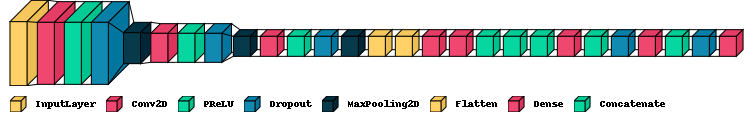

In [44]:
visualkeras.layered_view(modelo_vio, legend=True,scale_xy=1, scale_z=1, max_z=17)

### Entrenamiento

In [39]:
#entrenamos el modelo
model_path='Datos/'+nombre_modelo
hist_vio = modelo_vio.fit(dataset_train_modelo,  epochs=epoch_fit, callbacks=[cp_callback], validation_data=dataset_validation_modelo)

Epoch 1/300


519/519 [==============================] - 88s 135ms/step - loss: 2020.5636 - accuracy: 0.5346 - val_loss: 1064.3419 - val_accuracy: 0.5930
Epoch 2/300
514/519 [============================>.] - ETA: 0s - loss: 812.9144 - accuracy: 0.5956
Epoch 2: saving model to Datos/modelo_trial\cp-0002.ckpt
519/519 [==============================] - 80s 129ms/step - loss: 813.8904 - accuracy: 0.5958 - val_loss: 1191.8698 - val_accuracy: 0.6156
Epoch 3/300
519/519 [==============================] - 79s 126ms/step - loss: 668.4758 - accuracy: 0.6723 - val_loss: 1491.7601 - val_accuracy: 0.6538
Epoch 4/300
510/519 [============================>.] - ETA: 0s - loss: 596.9338 - accuracy: 0.6951
Epoch 4: saving model to Datos/modelo_trial\cp-0004.ckpt
519/519 [==============================] - 81s 131ms/step - loss: 596.2689 - accuracy: 0.6953 - val_loss: 1037.6610 - val_accuracy: 0.6914
Epoch 5/300
519/519 [==============================] - 82s 131ms/step - loss: 566.8943 - accuracy: 0.7063 - val_loss: 1

### Guardado del modelo en un archivo.h5

In [40]:
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

model_path= os.path.join(model_dir,nombre_modelo+'.h5')
modelo_vio.save(model_path)

with open(os.path.join(model_dir,"history.picke"), 'wb') as file_pi:
    pickle.dump(hist_vio.history, file_pi)

# Evaluar el modelo


### Resultados del entrenamiento

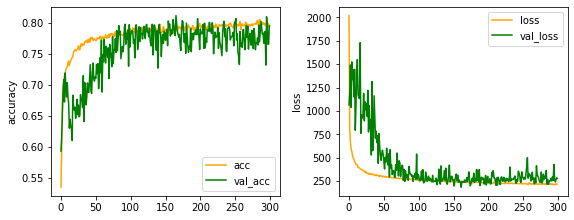

In [41]:
def show_results(hist_df):
  fig=plt.figure(figsize=(40, 30))

  # precision  - accuacy
  fig.add_subplot(10, 10, 1)
  plt.plot(hist_df.history['accuracy'], label='acc', color='orange')
  plt.plot(hist_df.history['val_accuracy'], label='val_acc', color='green')
  plt.ylabel('accuracy')
  plt.legend()

  #loss
  fig.add_subplot(10, 10, 2)
  plt.plot(hist_df.history['loss'], label='loss', color='orange')
  plt.plot(hist_df.history['val_loss'], label='val_loss', color='green')
  plt.ylabel('loss')
  plt.legend()

  plt.tight_layout()
  return plt.show()


show_results(hist_vio)

### Evaluación sobre un dataset que no ha sido usado dutante el entrenamiento

In [42]:
dataset_test = dataset_test_raw.map(lambda image_path, potencia, label:
                load_and_preprocess_image (image_path, potencia, label, jpg=False,size=(128,128))
                , num_parallel_calls=tf.data.AUTOTUNE)

dataset_test = dataset_test.batch(batch_size=batch_size, drop_remainder=False)
dataset_test = dataset_test.prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
loss, acc = modelo_vio.evaluate(dataset_test, verbose=2)
print('Accuracy del modelo: ', 100 * acc , "Error: ", loss)

162/162 - 20s - loss: 277.0848 - accuracy: 0.7958 - 20s/epoch - 120ms/step
Accuracy del modelo:  79.58276867866516 Error:  277.0848388671875
